In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import pyBigWig
import os
import umap
import scipy
from sklearn.preprocessing import StandardScaler
import statsmodels
from statannotations.Annotator import Annotator
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
targets = pd.read_csv('../data/enformer_targets_human.txt', sep='\t')
cre_size = 5000
model = custom_model.Enformer()

2024-01-24 01:54:47.058193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-24 01:54:47.489494: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 61273 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:07:00.0, compute capability: 8.0


In [5]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"



In [6]:
def plot_umap(all_features, labels):
    reducer = umap.UMAP(random_state=42)
    scaled_penguin_data = StandardScaler().fit_transform(all_features)
    embedding = reducer.fit_transform(scaled_penguin_data)
    print(embedding.shape)
    ax=sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1], hue=labels, alpha=0.3, palette=['g', 'r'])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [7]:
cre_classifier = 'sufficiency'

cres = pd.read_csv(f'../results/summary_csvs/enformer/sufficient_CREs.csv')

In [8]:
pdf_dir = utils.make_dir('pdfs/biochemistry/')

In [46]:
three_mark_dfs = []
for assay in ['histone', 'accessibility', 'tf']:
    all_features = []
    for cell_line in ['K562', 'GM12878', 'PC-3']:    
        metadata = pd.read_csv(f'../data/{cell_line}/{assay}/metadata.csv')        
        cell_df = cres[cres['cell_line']==cell_line]

        for m, metadata_row in metadata.iterrows(): # per bigwig track
            # get generic descriptors
            bw_id = metadata_row['File accession']
            
            if assay == 'accessibility':
                descr = metadata_row['Assay']
            else:
                descr = metadata_row['Experiment target'].split('-')[0]
                
            # read in values
            bw = pyBigWig.open(f'../data/{cell_line}/{assay}/{bw_id}.bigWig')
            
            for cre_type, df in cell_df.groupby('tile class'): 
                vals = []
                cre_types = []
                cre_id = []
                for i, row in df.iterrows():
                    chrom, tss = row['seq_id'].split('_')[1:3]
                    seq_start = int(tss) - model.seq_length//2
                    cre_start = seq_start + row['tile_start']
                    cre_end = cre_start + cre_size
                    v = bw.values(chrom, cre_start, cre_end)
                    vals.append(np.max(v))
                    cre_types.append(cre_type)
                    cre_id.append(f"{chrom}_{cre_start}_{cre_end}")
                df = pd.DataFrame([vals, cre_types, cre_id]).T
                df.columns=['Mean coverage', 'CRE type', 'CRE id']
                df['assay'] = assay
                df['cell line'] = cell_line    
                df['epigenetic mark'] = descr
                df['track_id'] = m
                
                all_features.append(df)
                
    all_features = pd.concat(all_features)
    three_mark_dfs.append(all_features)
histone_df, accessibility_df, tf_df = three_mark_dfs

# Histone marks

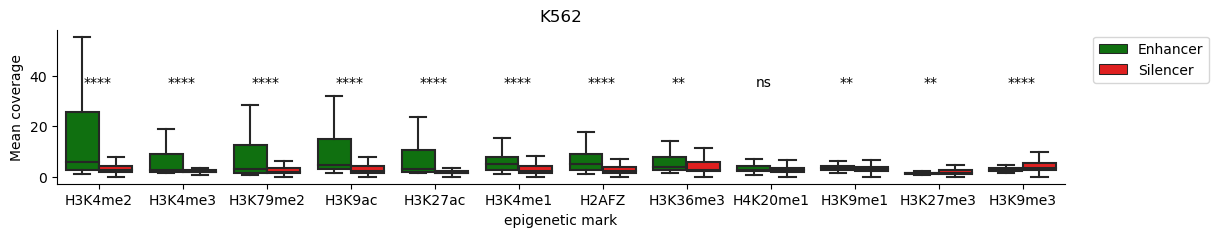

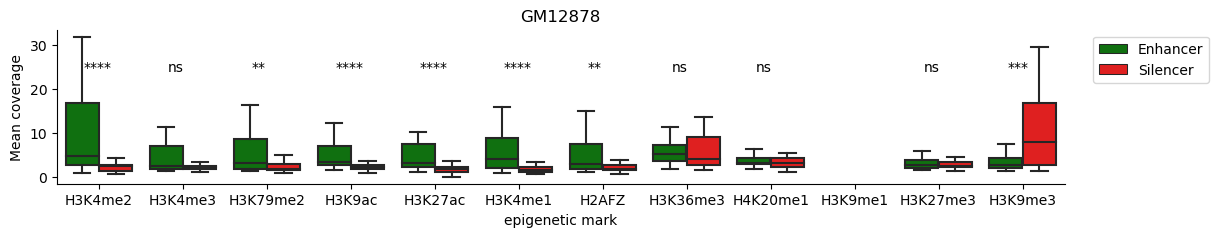

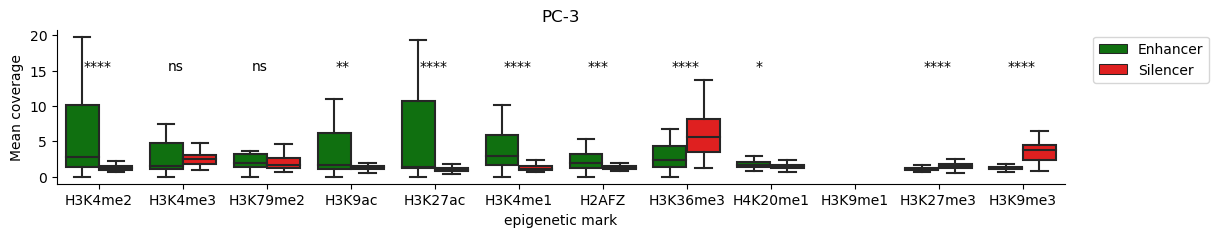

In [47]:
unique_histone_df = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    cell_line_hist_features = histone_df[histone_df['cell line']==cell_line]
    if cell_line == 'K562':
        epi_diff_vals = []
        for mark, mark_df in cell_line_hist_features.groupby('epigenetic mark'):
            enh_df, sil_df = [df['Mean coverage'].mean() for _, df in mark_df.groupby('CRE type')]
            diff = enh_df - sil_df
            epi_diff_vals.append([mark, diff])
        epi_diff_vals = pd.DataFrame(epi_diff_vals)
        hist_order = epi_diff_vals.sort_values(1)[0].values[::-1]

    mean_df = []
    for (mark, _), mark_df in cell_line_hist_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean()
        mark_df = mark_df.iloc[0]
        mean_df.append(mark_df)
    mean_df = pd.DataFrame(mean_df)
    unique_histone_df.append(mean_df)
    fig, axes = plt.subplots(1, figsize=[13,2])

    ax=sns.boxplot(data=mean_df.sort_values('CRE type'), x='epigenetic mark', y='Mean coverage', hue='CRE type', showfliers=False,
                   order=hist_order,
                  palette={'Enhancer':'g', 'Silencer':'r'})
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(cell_line)
    nobs = []
    for mark in hist_order:
        df = mean_df[mean_df['epigenetic mark'] == mark]
        if df.shape[0] > 0:
            annotation = convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(df[df['CRE type']=='Enhancer']['Mean coverage'].values, 
                                                                               df[df['CRE type']=='Silencer']['Mean coverage'].values)[1])
            nobs.append(annotation)
        else:
            nobs.append('')
    pos = range(len(nobs))

    for tick,label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick]-0.18,
                ax.get_yticks().max()*0.6,
                nobs[tick])
    plt.legend(bbox_to_anchor=[1.15,1])
    plt.show()
unique_histone_df = pd.concat(unique_histone_df)

# Accessibility

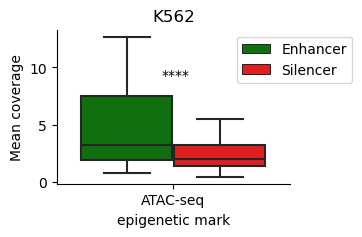

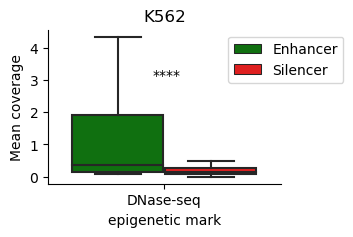

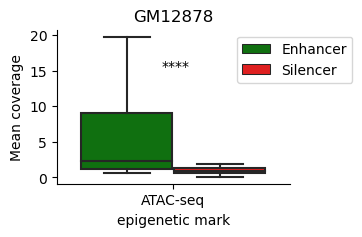

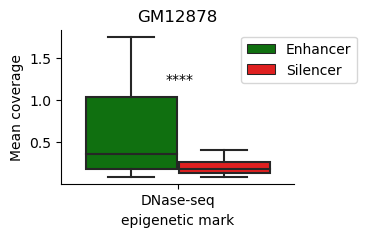

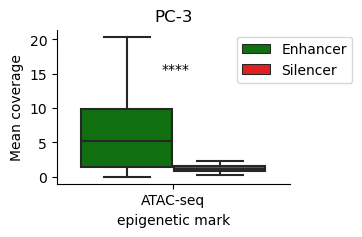

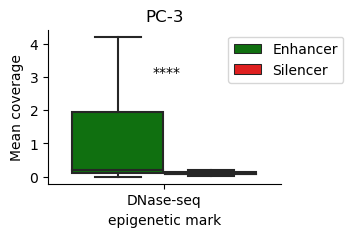

In [48]:
unique_acc_df = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    cell_line_acc_features = accessibility_df[accessibility_df['cell line']==cell_line]
    order = ['DNase-seq', 'ATAC-seq']

    mean_df = []
    for (mark, _), mark_df in cell_line_acc_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean()
        mark_df = mark_df.iloc[0]
        mean_df.append(mark_df)
    mean_df = pd.DataFrame(mean_df)
    unique_acc_df.append(mean_df)

    for acc_type, acc_df in mean_df.groupby('epigenetic mark'):
        fig, axes = plt.subplots(1, figsize=[3,2])
    
        ax=sns.boxplot(data=acc_df.sort_values('CRE type'), x='epigenetic mark', y='Mean coverage', hue='CRE type', showfliers=False,
                       # order=order,
                       
                      palette={'Enhancer':'g', 'Silencer':'r'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_title(cell_line)
        nobs = [convert_pvalue_to_asterisks(scipy.stats.mannwhitneyu(acc_df[acc_df['CRE type']=='Enhancer']['Mean coverage'].values, 
                                                                     acc_df[acc_df['CRE type']=='Silencer']['Mean coverage'].values)[1])]

        pos = range(len(nobs))
    
        for tick,label in zip(pos, ax.get_xticklabels()):
            ax.text(pos[tick]-0.05,
                    ax.get_yticks().max()*0.6,
                    nobs[tick])
        plt.legend(bbox_to_anchor=[1.3,1])
        plt.show()
unique_acc_df = pd.concat(unique_acc_df)

# TF

In [49]:
unique_tf_df = []
for cell_line in ['K562', 'GM12878', 'PC-3']:
    cell_line_tf_features = tf_df[tf_df['cell line']==cell_line]

    mean_df = []
    for (mark, _), mark_df in cell_line_tf_features.groupby(['epigenetic mark', 'CRE id']):
        if mark_df.shape[0] > 1:
            mark_df['Mean coverage'] = mark_df['Mean coverage'].values.mean()
        mark_df = mark_df.iloc[0]
        mean_df.append(mark_df)
    mean_df = pd.DataFrame(mean_df)
    unique_tf_df.append(mean_df)
unique_tf_df = pd.concat(unique_tf_df)

In [66]:
p_vals = []
fcs = []
logfc = []
marks = []
one_tf_df = unique_tf_df[unique_tf_df['cell line']=='K562']
for epi_mark, df in one_tf_df.groupby('epigenetic mark'):
    x = df[df['CRE type']=='Enhancer']['Mean coverage'].values
    y = df[df['CRE type']=='Silencer']['Mean coverage'].values
    p_val = scipy.stats.mannwhitneyu(x, y)[1]
    p_vals.append(p_val)
    logfc.append(np.log(x.mean()/y.mean()))
    fcs.append(x.mean()/y.mean())
    marks.append(epi_mark)

res = statsmodels.stats.multitest.multipletests(p_vals, method='bonferroni')[1]
adjusted_pvals = -np.log10(res)
df = pd.DataFrame([fcs, logfc, adjusted_pvals, p_vals, marks]).T
df.columns =  ['enhancer / silencer', 'log(enhancer / silencer)', '-log10(pvalue)', 'pvalue', 'mark']
p_thresh = -np.log10(0.05)
df['sign'] = [True if p> p_thresh else False for p in df['-log10(pvalue)'].values]
color_dict = {True: 'red', False: 'grey'}

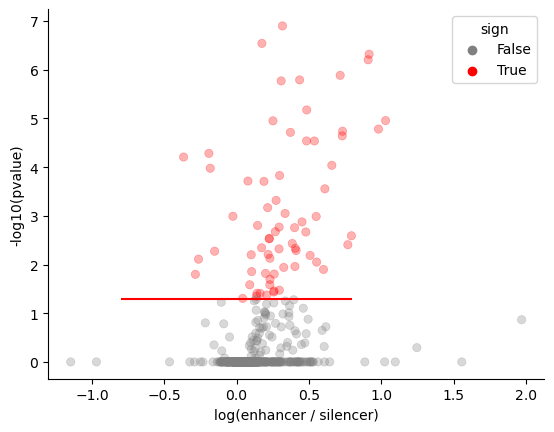

In [67]:
ax=sns.scatterplot(data=df, x='log(enhancer / silencer)', y='-log10(pvalue)', alpha=0.3, hue='sign', palette=color_dict, edgecolor=None)
p_thresh = -np.log10(0.05)
plt.hlines(p_thresh, -0.8, 0.8, color='r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

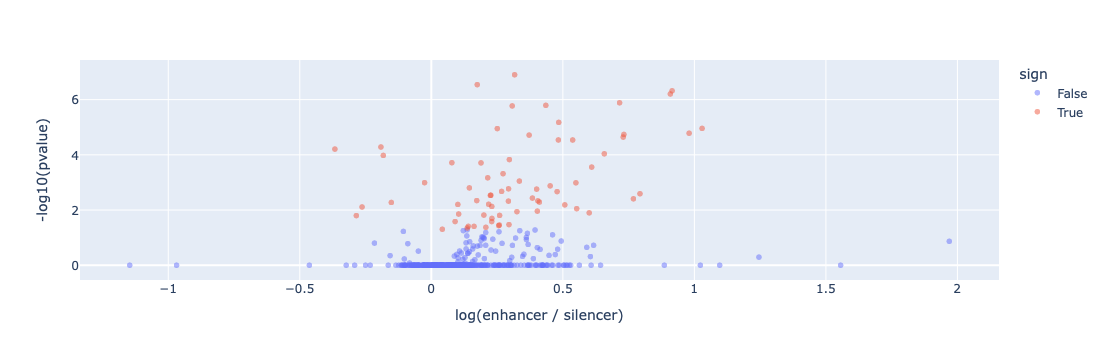

In [52]:
px.scatter(data_frame=df, x='log(enhancer / silencer)', y='-log10(pvalue)', color='sign', hover_data='mark', opacity=0.5)


# UMAP

In [40]:
significant_tfs = df[df['sign']]


In [63]:
significant_tf_df = []
for mark, one_mark_df in unique_tf_df.groupby('epigenetic mark'):
    if (mark in significant_tfs['mark'].values) and (significant_tfs[significant_tfs['mark']==mark]['log(enhancer / silencer)'].values > 0.3):
        significant_tf_df.append(one_mark_df)
significant_tf_df = pd.concat(significant_tf_df)

In [64]:
significant_tfs[significant_tfs['mark']==mark]['log(enhancer / silencer)']

Series([], Name: log(enhancer / silencer), dtype: object)

/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



(296, 2)


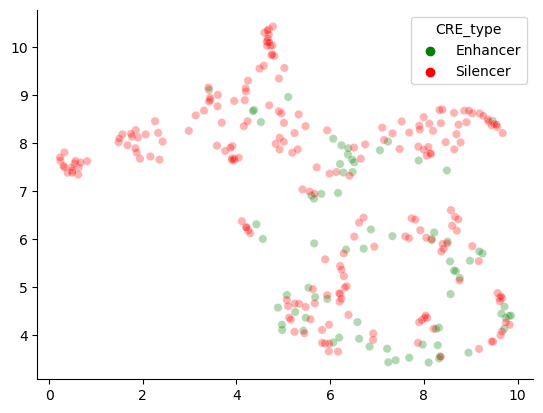

In [69]:
for cell_line in ['K562']:#, 'GM12878', 'PC-3']:
    enh_sil_features = []
    for cre_type in ['Enhancer', 'Silencer']:
        feature_set = []
        for df in [unique_histone_df]:#, unique_histone_df, unique_acc_df]:
            df = df[(df['cell line'] == cell_line) & (df['CRE type']==cre_type)].pivot(columns='epigenetic mark', 
                                                                                        index='CRE id', values='Mean coverage')
            feature_set.append(df)
        feature_set = pd.concat(feature_set, axis=1)
        feature_set['CRE_type'] = cre_type
        enh_sil_features.append(feature_set)
    enh_sil_features = pd.concat(enh_sil_features)
    plot_umap(enh_sil_features.iloc[:,:-1].values, enh_sil_features.iloc[:,-1])
    plt.show()

In [22]:
df[df['sign']]['mark'].values

array(['AFF1', 'AFF4', 'ARID1B', 'ARID2', 'ARID3A', 'ARNT', 'ATF3',
       'ATF4', 'ATF6', 'BACH1', 'BCOR', 'BHLHE40', 'BMI1', 'BRD4', 'BRD9',
       'CC2D1A', 'CDC5L', 'CEBPB', 'CGGBP1', 'CHD4', 'CTCF', 'CUX1',
       'CXXC5', 'DDIT3', 'DDX20', 'DEAF1', 'DMBX1', 'DMTF1', 'DNMT1',
       'DPF2', 'E2F1', 'E2F5', 'E2F8', 'E4F1', 'ELF1', 'ELK3', 'EP300',
       'EP400', 'ETV1', 'ETV5', 'ETV6', 'FOXA3', 'FOXK2', 'FOXM1',
       'FOXP4', 'GABPB1', 'HBP1', 'HCFC1', 'HDAC1', 'HDAC2', 'HDGF',
       'HES1', 'HINFP', 'HLTF', 'HMBOX1', 'HMG20A', 'HMGXB4', 'ID3',
       'IFI16', 'IKZF1', 'IRF1', 'JUN', 'JUND', 'KAT7', 'KAT8', 'KDM1A',
       'KHSRP', 'KLF6', 'LARP7', 'LCOR', 'LEF1', 'MAFF', 'MAFG', 'MAFK',
       'MAZ', 'MECOM', 'MIER1', 'MITF', 'MLLT1', 'MLX', 'MNT', 'MTA1',
       'MTA2', 'MTF1', 'MXI1', 'MYC', 'NBN', 'NCOA1', 'NCOR1', 'NFATC3',
       'NFRKB', 'NFXL1', 'NKRF', 'NR1H2', 'NR2C1', 'NR2F1', 'NR2F2',
       'NRF1', 'PHB2', 'PKNOX1', 'PML', 'PRDM10', 'PYGO2', 'RAD51',
       'RBFOX2

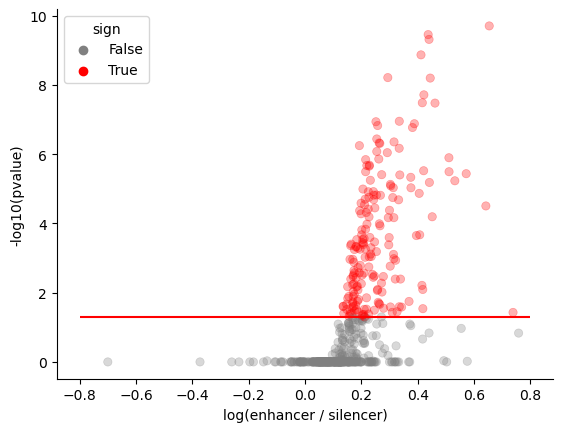

NameError: name 'df' is not defined

In [221]:
df[df['sign']].sort_values('log(enhancer / silencer)')['mark'].values

array(['PYGO2', 'ETV6', 'DMTF1', 'HINFP', 'ZNF707', 'ZNF512', 'MTF1',
       'DEAF1', 'CGGBP1', 'ARID2', 'ZNF79', 'DDIT3', 'NFXL1', 'LEF1',
       'SREBF2', 'NR2C1', 'ID3', 'TSHZ1', 'ZKSCAN8', 'TBPL1', 'ZNF449',
       'NR1H2', 'FOXP4', 'ZBTB43', 'YBX3', 'EP400', 'TCFL5', 'ZNF84',
       'ZFP91', 'ZNF696', 'KAT8', 'ELK3', 'IFI16', 'ZNF700', 'ZNF561',
       'LARP7', 'ZNF57', 'SMAD3', 'ZNF257', 'ZNF174', 'ZNF212', 'ZNF431',
       'KHSRP', 'IRF1', 'FOXA3', 'RFX7', 'TFE3', 'ZNF41', 'E4F1',
       'ZNF407', 'TCF15', 'ZC3H8', 'SP1', 'E2F5', 'BMI1', 'BACH1',
       'TFDP1', 'ZSCAN32', 'TRIM24', 'ZBTB26', 'ZNF316', 'MITF', 'HMG20A',
       'ZNF609', 'ARNT', 'ZNF76', 'MIER1', 'DNMT1', 'ZNF134', 'ZNF12',
       'AFF4', 'HBP1', 'DDX20', 'CDC5L', 'HLTF', 'ZNF586', 'TRIM25',
       'HES1', 'RHOXF2B', 'ZNF175', 'CUX1', 'ATF3', 'NCOA1', 'PHB2',
       'ZNF589', 'ZNF24', 'NFATC3', 'SMARCA5', 'MTA1', 'TOE1', 'ATF6',
       'CC2D1A', 'RFX5', 'TEAD1', 'RELA', 'NFRKB', 'MLLT1', 'ZBTB40',
       'AFF1', 